---
title: 8.7 序列到序列学习（seq2seq）
date: 2024-5-9 11:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 7 序列到序列学习（seq2seq）

- 使用两个循环神经网络的编码器和解码器，并将其应用于序列到序列（sequence to sequence，seq2seq）类的学习任务

![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/8_moden_rnn/6_seq_to_seq/1.png)
![](img/deeplearning/code/pytorch/8_moden_rnn/6_seq_to_seq/1.png)

- “\<eos>”表示序列结束词元。一旦输出序列生成此词元，模型就会停止预测。在循环神经网络解码器的初始化时间步，有两个特定的设计决定：首先，特定的“<bos>”表示序列开始词元，它是解码器的输入序列的第一个词元。其次，使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态。

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## 7.1 编码器

- 编码器将长度可变的输入序列转换成形状固定的上下文变量c，并且将输入序列的信息在该上下文变量中进行编码。

- 假设一个序列组成的样本（批量大小是1）。假设输入序列是$x_ 1, \ldots, x_ T$，其中$x_ t$是输入文本序列中的第$t$个词元。在时间步$t$，循环神经网络编码器将$x_ t$的词元特征向量$\boldsymbol{x}_ t$和$\boldsymbol{h}_ {t-1}$ 转换为隐状态$\boldsymbol{h}_ t$。使用一个函数f来描述rnn的循环层所做的变换：

$$\boldsymbol{h}_ t = f(\boldsymbol{x}_ t, \boldsymbol{h}_ {t-1}).$$

- 编码器通过选定的函数q，将所有时间步的隐状态转换为上下文变量：

$$\boldsymbol{c} = q(\boldsymbol{h}_ 1, \ldots, \boldsymbol{h}_ T).$$

- 到目前为止，我们使用的是一个单向循环神经网络来设计编码器，其中隐状态只依赖于输入子序列，这个子序列是由输入序列的开始位置到隐状态所在的时间步的位置（包括隐状态所在的时间步）组成。
- 也可以使用双向循环神经网络构造编码器，其中隐状态依赖于两个输入子序列，两个子序列是由隐状态所在的时间步的位置之前的序列和之后的序列（包括隐状态所在的时间步），因此隐状态对整个序列的信息都进行了编码。

- 我们使用了嵌入层（embedding layer）来获得输入序列中每个词元的特征向量。嵌入层的权重是一个矩阵，其行数等于输入词表的大小（vocab_size），其列数等于特征向量的维度（embed_size）。对于任意输入词元的索引i，嵌入层获取权重矩阵的第i行（从0开始）以返回其特征向量。另外，本文选择了一个多层门控循环单元来实现编码器。

In [3]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        # vocab_size:词典大小，用于将词典中一个分词转换为一个向量
        self.embedding = nn.Embedding(vocab_size, embed_size) # Embedding层用于讲（batch_size,num_steps）转换为（batch_size,num_steps,embed_size）
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # print('X：',X.shape)
        # x:[batch_size, num_steps]
        # 将一个分词转换成一个向量，之前的rnn使用的是one_hot
        X = self.embedding(X) #(batch_size,num_steps,embed_size)
        # print('X_emb：',X.shape)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)，隐藏状态
        return output, state # encoder输出y，h（最后一个时间步），还没有获得c

- 实例化上述编码器的实现：我们使用一个两层门控循环单元编码器，其隐藏单元数为16。给定一小批量的输入序列X（批量大小为4，时间步为7）。在完成所有时间步后，最后一层的隐状态的输出是一个张量（output由编码器的循环层返回），其形状为（时间步数，批量大小，隐藏单元数）。由于这里使用的是门控循环单元，所以在最后一个时间步的多层隐状态的形状是（隐藏层的数量，批量大小，隐藏单元的数量）。如果使用长短期记忆网络，state中还将包含记忆单元信息。

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape #[T,batch,num_hiddens],[num_layers,batch,num_hiddens]

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

## 7.2 解码器

- 来自训练数据集的输出序列$y_ 1, y_ 2, \ldots, y_ T'$，对于每个时间步$t'$（与输入序列或编码器的时间步t不同），解码器输出$y_ {t'}$的概率取决于之前的输出子序列$y_ 1, \ldots, y_ {t'-1}$和上下文变量c，即$p(y_ {t'} \mid y_ 1, \ldots, y_ {t'-1}, \boldsymbol{c})$。

- 在输出序列上的任意时间步$t'$，rnn将来自上一时间步的输出$y_ {t'-1}$和上下文变量c作为其输入，然后在当前时间步将它们和上一隐状态$\boldsymbol{s}_ {t'-1}$转换为当前隐状态$\boldsymbol{s}_ {t'}$。因此，我们使用一个函数g来描述rnn的隐藏层的变换：

$$\boldsymbol{s}_ {t'} = g(y_ {t'-1}, \boldsymbol{s}_ {t'-1}, \boldsymbol{c}).$$

- 获得解码器的隐状态之后，我们可以使用输出层和softmax操作来计算在时间步$t'$时输出$y_ {t'}$的条件概率分布$p(y_ {t'} \mid y_ 1, \ldots, y_ {t'-1}, \boldsymbol{c})$。

- 实现解码器时，我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。为了进一步包含经过编码的输入序列的信息，上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。为了预测输出词元的概率分布，在循环神经网络解码器的最后一层使用全连接层来变换隐状态。

In [26]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2) 
        # 广播`context`，使其具有与`X`相同的`num_steps`
        # print(X.shape)# [7,4,8]
        # print(state[-1].shape) # [4, 16]
        # 将编码器的隐藏状态广播到和X一样的形状，得到解码器的隐状态，也作为context
        context = state[-1].repeat(X.shape[0], 1, 1) #用编码器最后一层的最后一个时间步的隐状态作为context
        # print(context.shape)#[7, 4, 16]
        X_and_context = torch.cat((X, context), 2) # 将x和context拼接，
        # print(X_and_context.shape)# [7, 4, 24]
        output, state = self.rnn(X_and_context, state) #“用编码器的最后一个时间步的隐状态初始化解码器的隐状态”
        output = self.dense(output).permute(1, 0, 2)
        # `output`的形状：(batch_size,num_steps,vocab_size)
        # `state`的形状：(num_layers,batch_size,num_hiddens)
        return output, state

- 用与前面提到的编码器中相同的超参数来实例化解码器。

In [27]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

torch.Size([7, 4, 24])


(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

- 模型结构

![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/8_moden_rnn/6_seq_to_seq/2.png)
![](img/deeplearning/code/pytorch/8_moden_rnn/6_seq_to_seq/2.png)

## 7.3 损失函数

- 在每个时间步，解码器预测了输出词元的概率分布。类似于语言模型，可以使用softmax来获得分布，并通过计算交叉熵损失函数来进行优化。特定的填充词元被添加到序列的末尾，因此不同长度的序列可以以相同形状的小批量加载。但是，我们应该将填充词元的预测排除在损失函数的计算之外。

- sequence_mask函数通过零值化屏蔽不相关的项，以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。例如，如果两个序列的有效长度（不包括填充词元）分别为1和2，则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。

In [28]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1) # 序列的最大长度
    # 生成[0,1,2,3,...,maxlen-1]，然后与valid_len比较,valid_len之前的位置为1，之后的位置为0
    # [None, :]在行上增加一个维度
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

- 还可以使用此函数屏蔽最后几个轴上的所有项。如果愿意，也可以使用指定的非零值来替换这些项。

In [29]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

- 通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。最初，所有预测词元的掩码都设置为1。一旦给定了有效长度，与填充词元对应的掩码将被设置为0。最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [30]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # `pred`的形状：(batch_size,seq_len,vocab_size)
    # `label`的形状：(batch_size,seq_len)
    # `valid_len`的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

- 检测：创建三个相同的序列，分别指定这些序列的有效长度为4、2和0。第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。

In [31]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))


tensor([2.3026, 1.1513, 0.0000])

## 7.4 训练

- 开始词元（“\<bos>”）和原始的输出序列（不包括序列结束词元“\<eos>”）拼接在一起作为解码器的输入。这被称为强制教学（teacher forcing），因为原始的输出序列（词元的标签）被送入解码器。或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [32]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch] # Y是翻译后的语言
            # 生成Y.shape[0]个'<bos>'标记
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学, bos+Y[:-1]，使用了T-1个时间步
            # print(Y[:, :-1].shape)
            # print(Y.shape)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # 损失函数求和
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum() # 
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

- 创建和训练一个循环神经网络“编码器－解码器”模型用于序列到序列的学习。

loss 0.019, 9991.3 tokens/sec on cpu


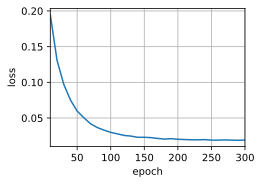

In [33]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs,device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 7.5 预测

- 为了采用一个接着一个词元的方式预测输出序列，每个解码器当前时间步的输入都将来自于前一时间步的预测词元。与训练类似，序列开始词元（“\<bos>”）在初始时间步被输入到解码器中。当输出序列的预测遇到序列结束词元（“\<eos>”）时，预测就结束了。

![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/8_moden_rnn/6_seq_to_seq/1.png)
![](img/deeplearning/code/pytorch/8_moden_rnn/6_seq_to_seq/1.png)

In [34]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将`net`设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>']) # 讲src_tokens填充到num_steps长度
    # 添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的标记，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束标记被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## 7.6 预测序列的评估

- 可以通过与真实的标签序列进行比较来评估预测序列。对于预测序列中的任意n元语法（n‐grams），BLEU的评估都是这个n元语法是否出现在标签序列中。我们将BLEU定义为：

$$ exp(min(0, 1 - \frac{len_ { label }}{len_ { pred }})) \prod_ {n=1} ^k P_ n^ {1/2^ n}.$$

- 其中$len_ { label }$是标签序列中的词元数，$len_ { pred }$是预测序列的词元数，k是用于匹配的最长的n元语法。$P_ n$是n元语法的精确度，它是两个数量的比值：第一个是预测序列与标签序列中匹配的n元语法的数量，第二个是预测序列中n元语法的数量的比率。给定标签序列A、B、C、D、E、F 和预测序列A、B、B、C、D，我们有$p_ 1 = 4/5, p_ 2 = 3/4, p_ 3 = 1/3, p_ 4 = 0$。

- 当预测序列与标签序列完全相同时，BLEU为1。此外，由于n元语法越长则匹配难度越大，所以BLEU为更长的n元语法的精确度分配更大的权重。具体来说，当$P_ n$固定时，$P_ n^ {1/2^ n}$随着n的增加而减小。而且，由于预测的序列越短获得的$p_ n$值越高，所以乘法项之前的系数用于惩罚较短的预测序列。例如，当k = 2时，给定标签序列A、B、C、D、E、F 和预测序列A、B，尽管$p_ 1 = 2/2, p_ 2 = 1/1, p_ 3 = p_ 4 = 0$，乘法因子$exp(1-6/2) \approx 0.14$将降低BLEU的值。


In [35]:
def bleu(pred_seq, label_seq, k):
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

- 利用训练好的循环神经网络“编码器－解码器”模型，将几个英语句子翻译成法语，并计算BLEU的最终结果。

In [36]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')


torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
go . => va doucement !, bleu 0.000
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
i lost . => j'ai perdu ., bleu 1.000
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
he's calm . => il est mouillé moi <unk> !, bleu 0.386
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
i'm home . => je suis riche riche bien parti parti bien parti bien, bleu 0.258
